# Identifying PII in Luganda Dataset using NER


    ## Introduction
    This notebook focuses on using a Luganda language dataset to identify Personally Identifiable Information (PII) using Named Entity Recognition (NER) techniques. We will load a pre-existing Luganda NER dataset, preprocess the data, train a model, and then use it to predict and identify PII in the dataset.
    

## Installing Required Libraries

In [3]:

!pip install datasets transformers seqeval wandb accelerate torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 

## Importing Modules

In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
import torch


## Loading the Luganda Dataset

In [5]:

raw_datasets = load_dataset("Conrad747/lg-ner")


Generating train split:   0%|          | 0/2085 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/536 [00:00<?, ? examples/s]

In [6]:
# Calculating the number of samples in each split (train, validation, test)
num_train_samples = len(raw_datasets['train'])
num_val_samples = len(raw_datasets['validation'])
num_test_samples = len(raw_datasets['test'])

# Printing the sizes of the dataset splits
print("Number of samples in the training set:", num_train_samples)
print("Number of samples in the validation set:", num_val_samples)
print("Number of samples in the test set:", num_test_samples)

Number of samples in the training set: 2085
Number of samples in the validation set: 358
Number of samples in the test set: 536


In [7]:
# Listing the features included in the dataset
print("Features included in the dataset:")
for feature_name, feature_data in raw_datasets['train'].features.items():
    print(f"- {feature_name}: {feature_data.dtype}")

Features included in the dataset:
- id: string
- tokens: list
- ner_tags: list


Sample from the training set:
{'id': '0', 'tokens': ['bassentebe', 'be', '##byalo', 'balabuddwa', 'okukomya', 'okusabiriza', 'kubanga', 'baalondebwa', 'abantu', 'nga', 'bee', '##sobola', 'era', 'neba', '##ba', '##kuutira', 'obuta', '##tunda', 'buga', '##ali', 'bu', 'maanyi', 'ga', 'kifuba', 'obwa', 'babee', '##wereddwa', 'gavumenti', 'kubanga', 'kya', 'bugagga', 'kya', 'kyalo', 'ekirina', 'n', "'", 'okusigala', 'mu', 'woofiisi', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

NER tags for the sample:
bassentebe: 0
be: 0
##byalo: 0
balabuddwa: 0
okukomya: 0
okusabiriza: 0
kubanga: 0
baalondebwa: 0
abantu: 0
nga: 0
bee: 0
##sobola: 0
era: 0
neba: 0
##ba: 0
##kuutira: 0
obuta: 0
##tunda: 0
buga: 0
##ali: 0
bu: 0
maanyi: 0
ga: 0
kifuba: 0
obwa: 0
babee: 0
##wereddwa: 0
gavumenti: 0
kubanga: 0
kya: 0
bugagga: 0
kya: 0
kyalo: 0
ekirina: 0
n: 0
': 0
okusigala: 0
mu: 0
woofiisi: 0
.: 0


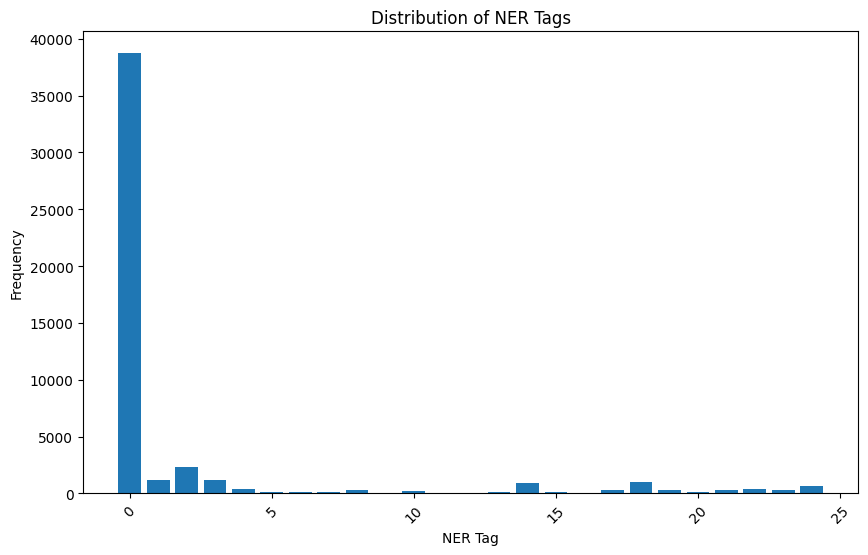

In [8]:
# Displaying a sample of the dataset
print("Sample from the training set:")
print(raw_datasets['train'][0])

# Displaying NER tags for the sample
sample_tokens = raw_datasets['train'][0]['tokens']
sample_ner_tags = raw_datasets['train'][0]['ner_tags']
print("\nNER tags for the sample:")
for token, ner_tag in zip(sample_tokens, sample_ner_tags):
    print(f"{token}: {ner_tag}")

# Visualizing NER tags distribution
import matplotlib.pyplot as plt

# Counting occurrences of each NER tag in the training set
ner_tag_counts = {}
for sample in raw_datasets['train']:
    for ner_tag in sample['ner_tags']:
        ner_tag_counts[ner_tag] = ner_tag_counts.get(ner_tag, 0) + 1

# Plotting the distribution of NER tags
plt.figure(figsize=(10, 6))
plt.bar(ner_tag_counts.keys(), ner_tag_counts.values())
plt.title('Distribution of NER Tags')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Preprocessing steps description
Preprocessing Steps:
1. Tokenization:
   - Text sequences were tokenized using the AutoTokenizer with truncation and padding to ensure uniform length sequences.
2. Alignment of Labels:
   - Named Entity Recognition (NER) tags were aligned with the tokenized inputs to maintain consistency between tokens and labels.


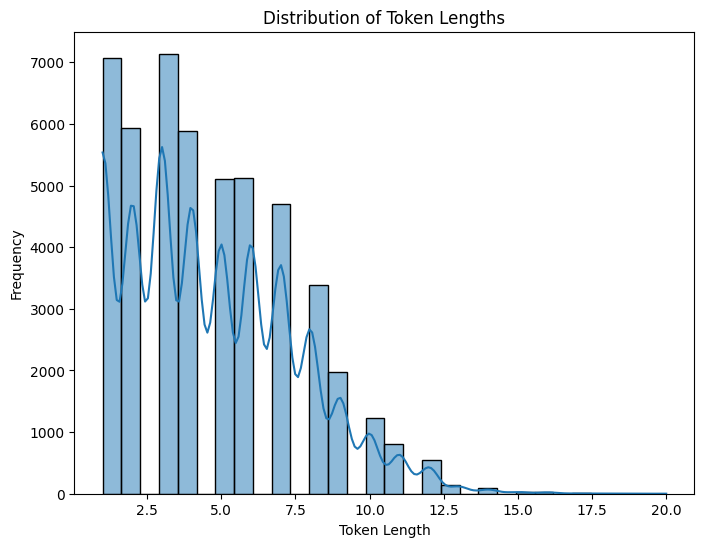

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualization 1: Distribution of token lengths
token_lengths = [len(token) for sample in raw_datasets['train'] for token in sample['tokens']]
plt.figure(figsize=(8, 6))
sns.histplot(token_lengths, bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()


This visualization displays the distribution of token lengths in the dataset. The x-axis represents the length of tokens, while the y-axis represents the frequency of tokens with that length. The histogram shows the spread of token lengths in the dataset.



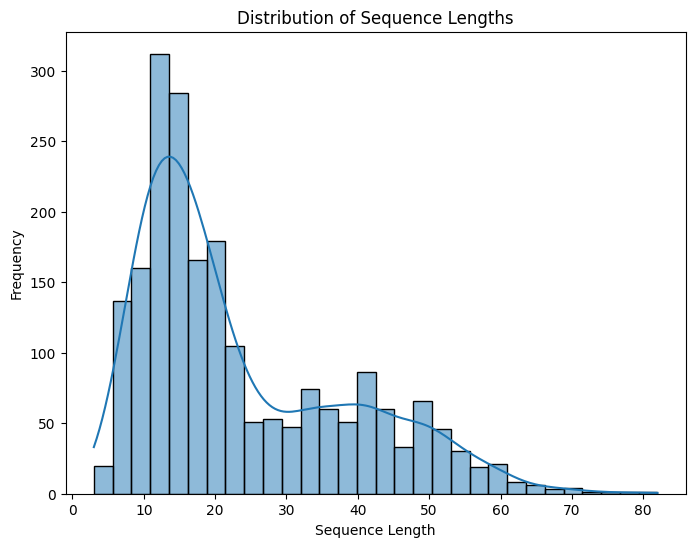

In [10]:
# Visualization 2: Distribution of sequence lengths
sequence_lengths = [len(sample['tokens']) for sample in raw_datasets['train']]
plt.figure(figsize=(8, 6))
sns.histplot(sequence_lengths, bins=30, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


This visualization illustrates the distribution of sequence lengths in the dataset. Sequence length refers to the number of tokens in each sequence. The histogram provides insights into the variation in sequence lengths across the dataset.

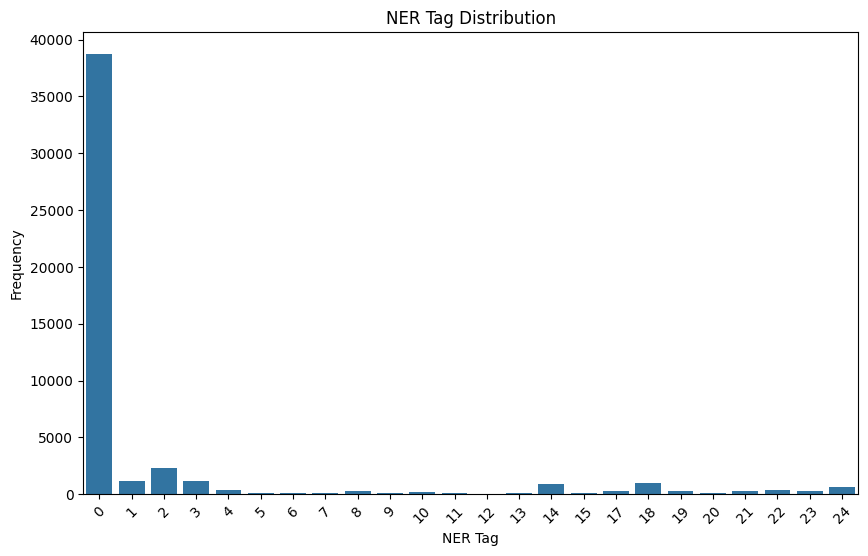

In [11]:
# Visualization 3: NER tag distribution across different entity types
ner_tags = [tag for sample in raw_datasets['train'] for tag in sample['ner_tags']]
plt.figure(figsize=(10, 6))
sns.countplot(x=ner_tags)
plt.title('NER Tag Distribution')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


This visualization shows the distribution of NER (Named Entity Recognition) tags across different entity types. Each NER tag corresponds to a specific entity type such as person, organization, location, etc. The countplot displays the frequency of each NER tag in the dataset.

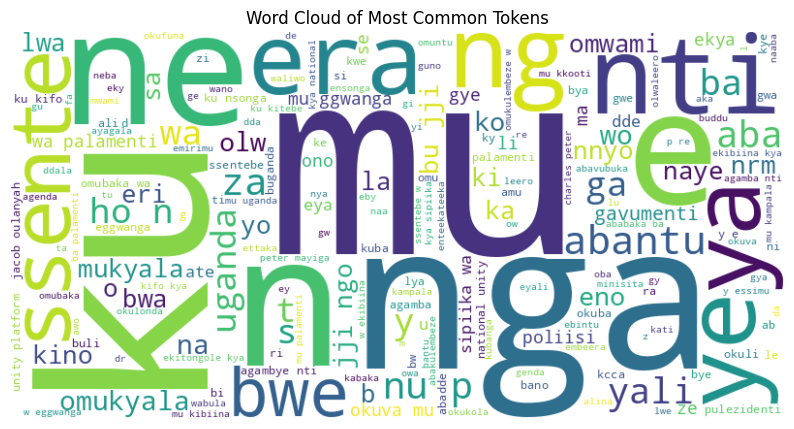

In [12]:
# Visualization 4: Word cloud of most common tokens
all_tokens = [token for sample in raw_datasets['train'] for token in sample['tokens']]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Most Common Tokens')
plt.axis('off')
plt.show()


This word cloud visualization depicts the most common tokens in the dataset. The size of each word in the cloud corresponds to its frequency in the dataset. It provides a visual representation of the distribution of tokens and highlights the most frequent terms.

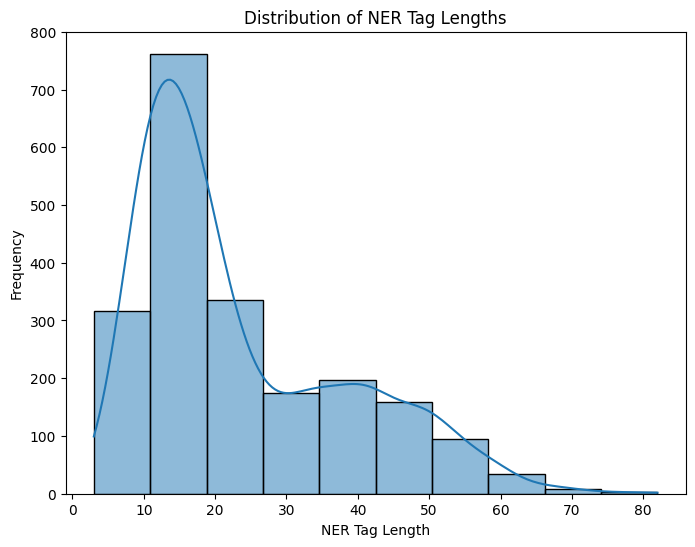

In [13]:
# Visualization 5: Distribution of NER tag lengths
ner_lengths = [len(tag) for tag in raw_datasets['train']['ner_tags']]
plt.figure(figsize=(8, 6))
sns.histplot(ner_lengths, bins=10, kde=True)
plt.title('Distribution of NER Tag Lengths')
plt.xlabel('NER Tag Length')
plt.ylabel('Frequency')
plt.show()


This histogram displays the distribution of NER tag lengths in the dataset. The x-axis represents the length of NER tags, while the y-axis represents the frequency of NER tags with that length. It provides insights into the variability in NER tag lengths across the dataset.

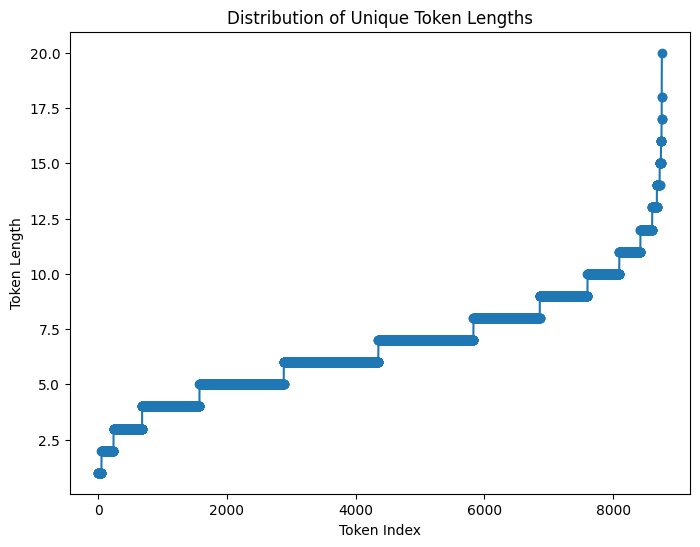

In [14]:
# Visualization 6: Distribution of unique tokens
unique_tokens = set(all_tokens)
plt.figure(figsize=(8, 6))
plt.plot(sorted([len(token) for token in unique_tokens]), marker='o')
plt.title('Distribution of Unique Token Lengths')
plt.xlabel('Token Index')
plt.ylabel('Token Length')
plt.show()


This line plot visualizes the distribution of unique token lengths in the dataset. Each point on the plot represents the length of a unique token, sorted by token index. It helps in understanding the diversity of token lengths in the dataset.

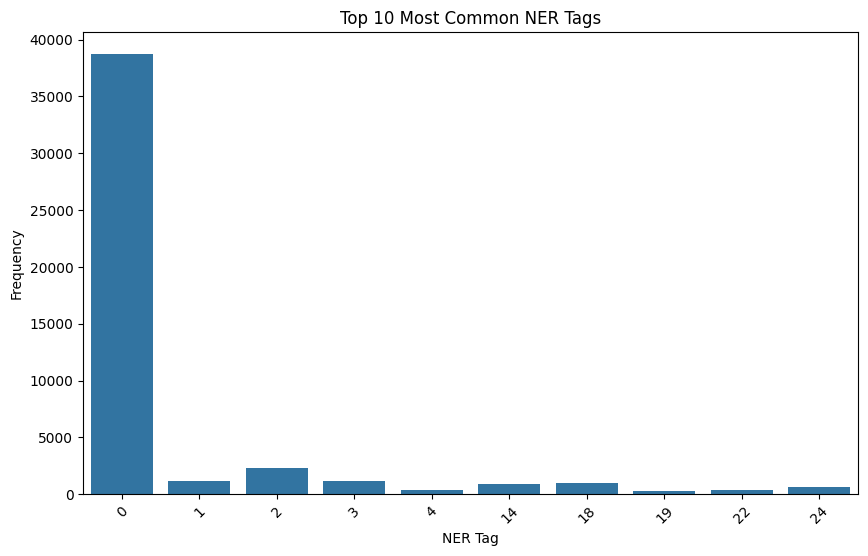

In [15]:
# Visualization 7: Top 10 most common NER tags
top_ner_tags = pd.Series(ner_tags).value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ner_tags.index, y=top_ner_tags.values)
plt.title('Top 10 Most Common NER Tags')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


This bar plot displays the top 10 most common NER tags in the dataset along with their frequencies. It helps in identifying the most prevalent entity types recognized by the NER model.

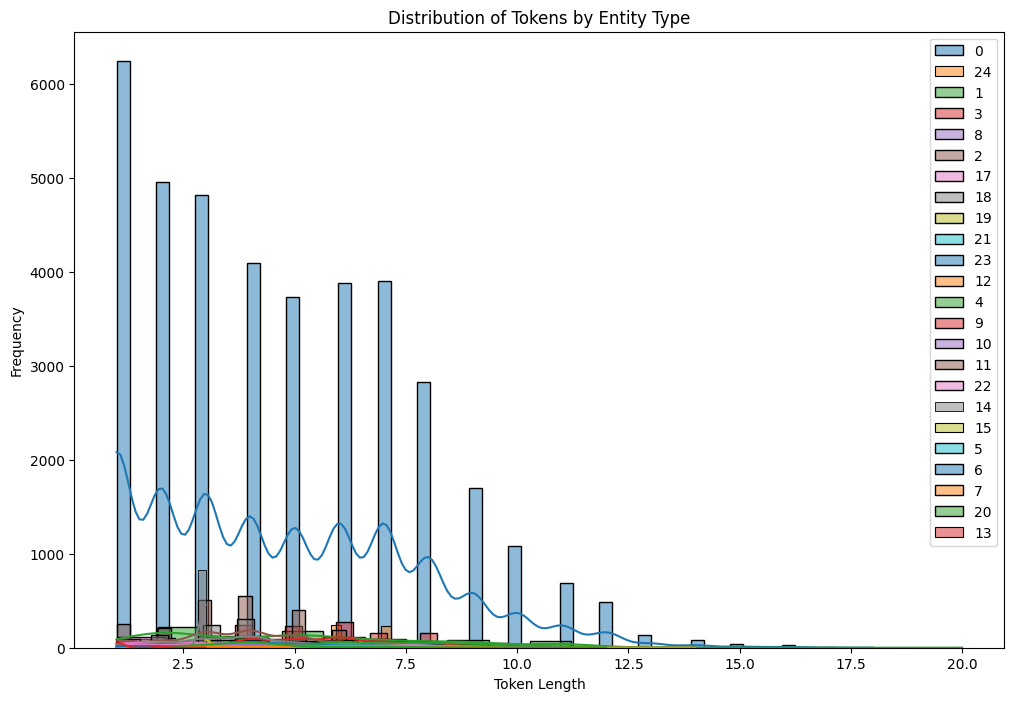

In [16]:
# Visualization 8: Distribution of tokens by entity type
entity_type_counts = {}
for sample in raw_datasets['train']:
    for token, ner_tag in zip(sample['tokens'], sample['ner_tags']):
        if ner_tag != 'O':
            if ner_tag not in entity_type_counts:
                entity_type_counts[ner_tag] = []
            entity_type_counts[ner_tag].append(token)

plt.figure(figsize=(12, 8))
for ner_tag, tokens in entity_type_counts.items():
    sns.histplot([len(token) for token in tokens], label=ner_tag, kde=True, alpha=0.5)
plt.title('Distribution of Tokens by Entity Type')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


This visualization depicts the distribution of tokens categorized by their entity types. Each entity type is represented by a different color in the histogram. It helps in understanding the token length distribution for each entity type.



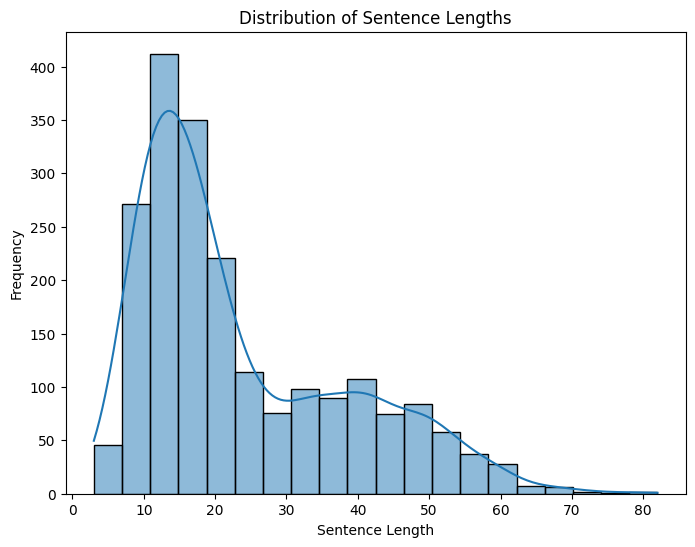

In [17]:
# Visualization 9: Distribution of sentence lengths
sentence_lengths = [len(sample['tokens']) for sample in raw_datasets['train']]
plt.figure(figsize=(8, 6))
sns.histplot(sentence_lengths, bins=20, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


This histogram visualizes the distribution of sentence lengths in the dataset. It helps in understanding the variability in the length of sentences, which can be useful for modeling purposes.

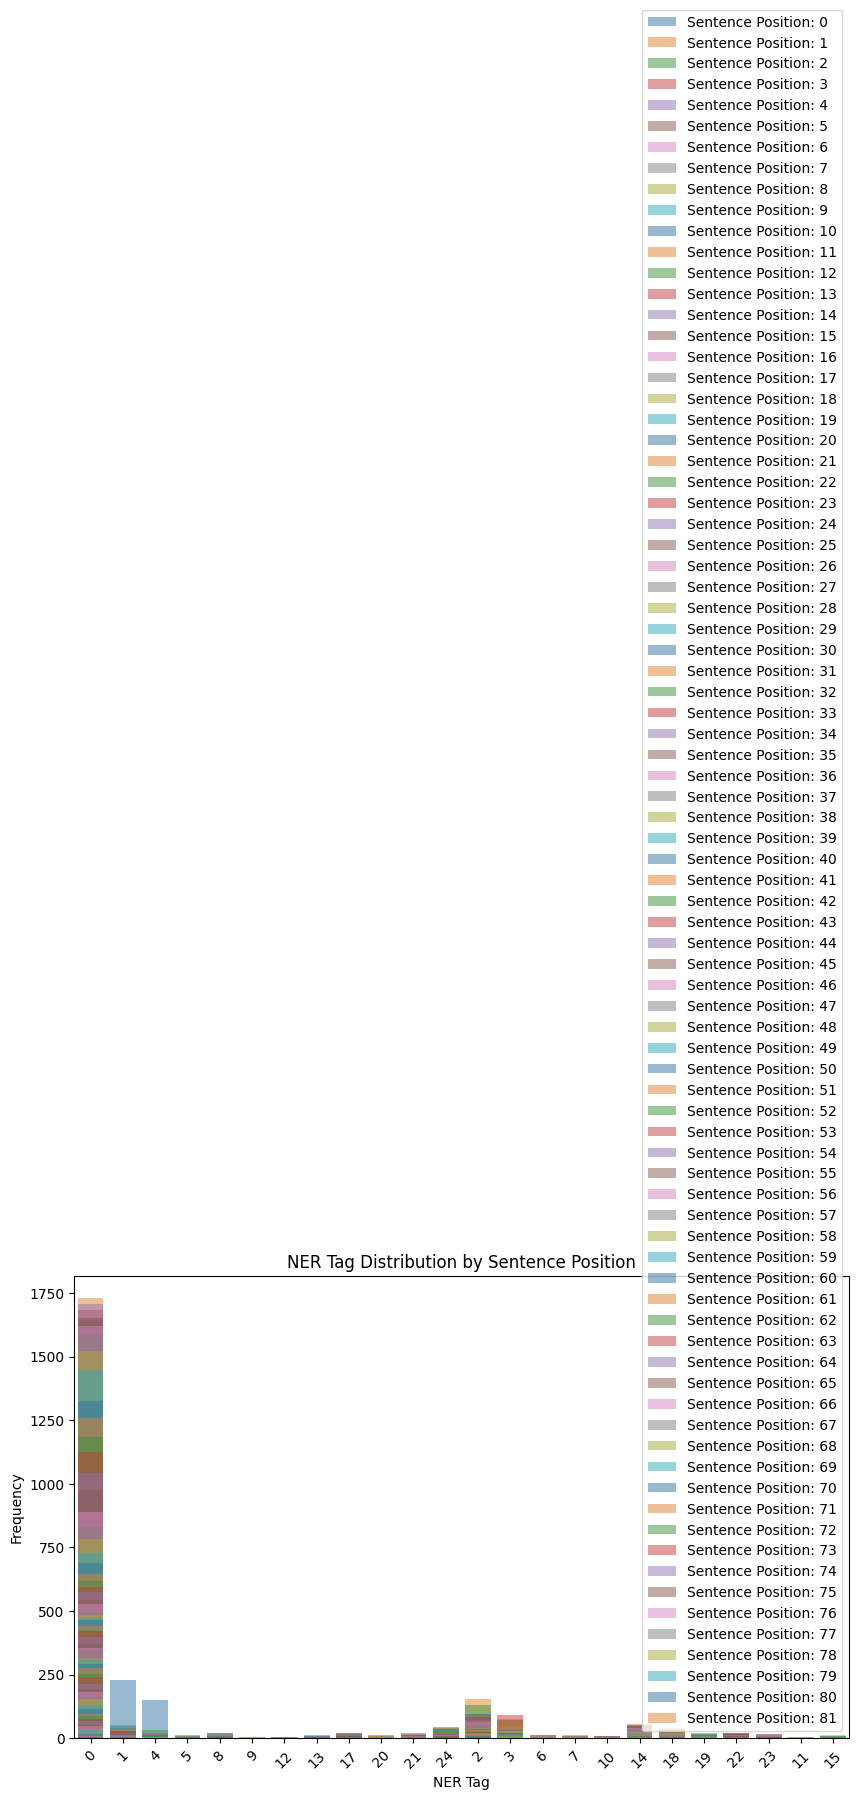

In [18]:
# Visualization 10: NER tag distribution by sentence position
ner_by_position = {}
for sample in raw_datasets['train']:
    for i, ner_tag in enumerate(sample['ner_tags']):
        if ner_tag != 'O':
            if i not in ner_by_position:
                ner_by_position[i] = []
            ner_by_position[i].append(ner_tag)

plt.figure(figsize=(10, 6))
for position, ner_tags in ner_by_position.items():
    ner_counts = pd.Series(ner_tags).value_counts()
    sns.barplot(x=ner_counts.index, y=ner_counts.values, alpha=0.5, label=f'Sentence Position: {position}')
plt.title('NER Tag Distribution by Sentence Position')
plt.xlabel('NER Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()


This bar plot illustrates the distribution of NER tags based on their position within sentences. Each bar represents the frequency of NER tags observed at a specific sentence position. It provides insights into how NER tags are distributed across different positions within sentences.

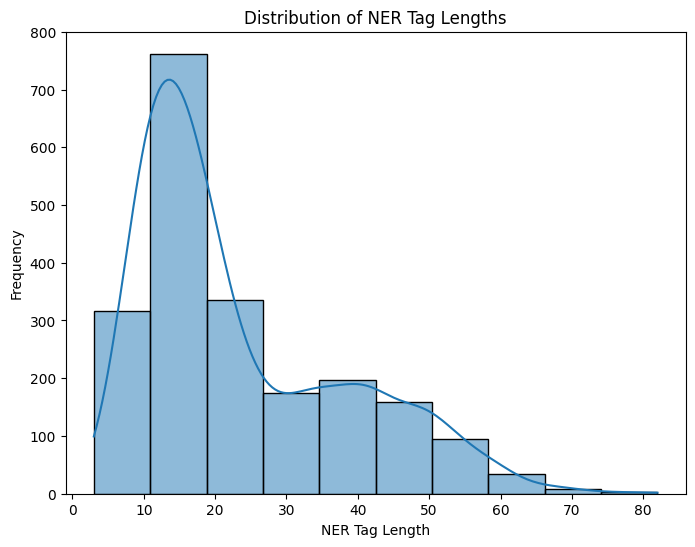

In [21]:
# Visualization 11: Distribution of NER tag lengths
ner_tags = raw_datasets['train']['ner_tags']
ner_tag_lengths = [len(tag) for tag in ner_tags if tag != 'O']
plt.figure(figsize=(8, 6))
sns.histplot(ner_tag_lengths, bins=10, kde=True)
plt.title('Distribution of NER Tag Lengths')
plt.xlabel('NER Tag Length')
plt.ylabel('Frequency')
plt.show()


This histogram visualizes the distribution of lengths of non-'O' NER tags in the dataset. Understanding the distribution of NER tag lengths can help in preprocessing and feature engineering, especially when dealing with complex entity types.

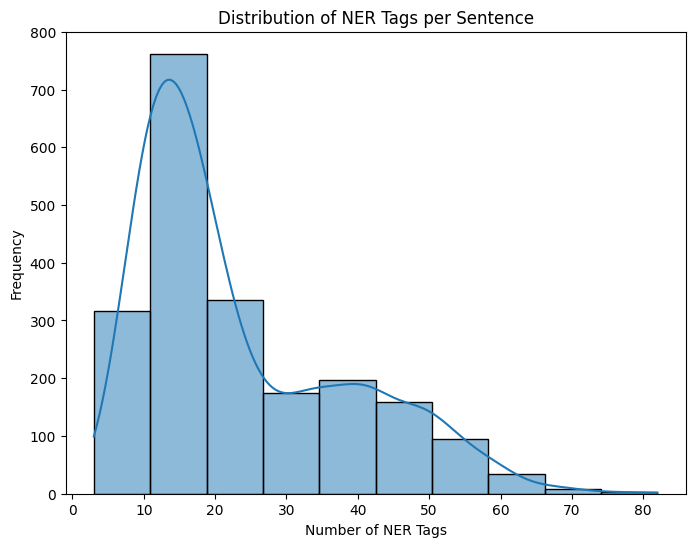

In [26]:
# Visualization 12: Distribution of NER tags per sentence
ner_tags_per_sentence = [sum(1 for tag in sample['ner_tags'] if tag != 'O') for sample in raw_datasets['train']]
plt.figure(figsize=(8, 6))
sns.histplot(ner_tags_per_sentence, bins=10, kde=True)
plt.title('Distribution of NER Tags per Sentence')
plt.xlabel('Number of NER Tags')
plt.ylabel('Frequency')
plt.show()


This histogram illustrates the distribution of the number of NER tags per sentence in the dataset. It provides insights into the complexity and density of entity mentions within sentences, which can influence model design and performance.

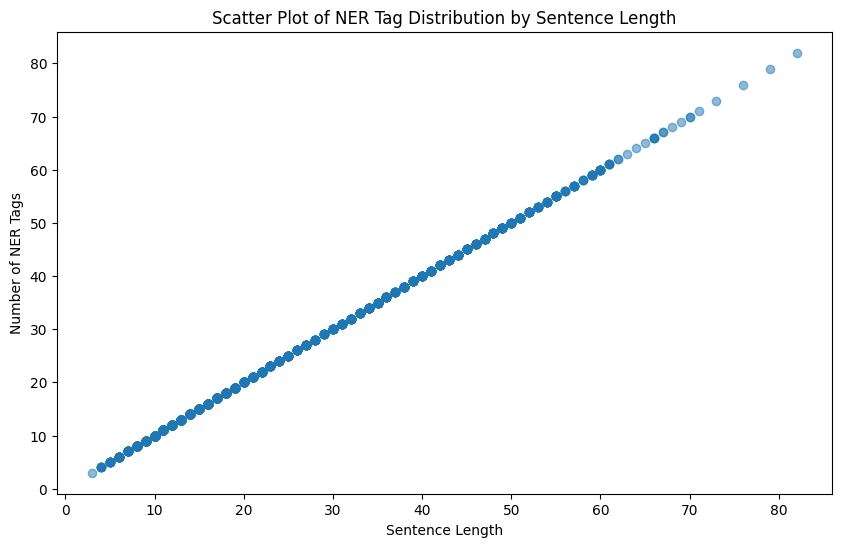

In [24]:
# Visualization 13: Scatter plot of NER tag distribution by sentence length
plt.figure(figsize=(10, 6))
plt.scatter(sentence_lengths, ner_tags_per_sentence, alpha=0.5)
plt.title('Scatter Plot of NER Tag Distribution by Sentence Length')
plt.xlabel('Sentence Length')
plt.ylabel('Number of NER Tags')
plt.show()


This scatter plot visualizes the relationship between sentence length and the number of NER tags. Each point represents a sentence, with its x-coordinate being the sentence length and y-coordinate being the number of NER tags. It helps in identifying any patterns or correlations between these two variables.

## Model Implementation



In [32]:
# test
from transformers import pipeline
classify = pipeline('ner', model='Conrad747/luganda-ner-v6')


In [33]:
classify("Ssemakula yategese ekivvulu okutalaaga ebitundu omuli Buddu ne Bulemeezi.")

[{'entity': 'U-PERSON',
  'score': 0.99280775,
  'index': 1,
  'word': '▁S',
  'start': 0,
  'end': 1},
 {'entity': 'U-PERSON',
  'score': 0.99316794,
  'index': 2,
  'word': 'sema',
  'start': 1,
  'end': 5},
 {'entity': 'U-PERSON',
  'score': 0.9923395,
  'index': 3,
  'word': 'kula',
  'start': 5,
  'end': 9},
 {'entity': 'U-LOCATION',
  'score': 0.98908883,
  'index': 21,
  'word': '▁Budd',
  'start': 54,
  'end': 58},
 {'entity': 'U-LOCATION',
  'score': 0.98924583,
  'index': 22,
  'word': 'u',
  'start': 58,
  'end': 59},
 {'entity': 'U-LOCATION',
  'score': 0.9888341,
  'index': 24,
  'word': '▁Bu',
  'start': 63,
  'end': 65},
 {'entity': 'U-LOCATION',
  'score': 0.98705053,
  'index': 25,
  'word': 'leme',
  'start': 65,
  'end': 69},
 {'entity': 'U-LOCATION',
  'score': 0.987199,
  'index': 26,
  'word': 'ezi',
  'start': 69,
  'end': 72}]

In [35]:
classify("Katikiro Ssebugwaawo asisinkanye Minisita wa Kampala Minsa Kabanda")

[{'entity': 'B-PERSON',
  'score': 0.9932799,
  'index': 1,
  'word': '▁Kati',
  'start': 0,
  'end': 4},
 {'entity': 'B-PERSON',
  'score': 0.9935499,
  'index': 2,
  'word': 'ki',
  'start': 4,
  'end': 6},
 {'entity': 'B-PERSON',
  'score': 0.9925648,
  'index': 3,
  'word': 'ro',
  'start': 6,
  'end': 8},
 {'entity': 'L-PERSON',
  'score': 0.9937006,
  'index': 4,
  'word': '▁S',
  'start': 9,
  'end': 10},
 {'entity': 'L-PERSON',
  'score': 0.99294513,
  'index': 5,
  'word': 'se',
  'start': 10,
  'end': 12},
 {'entity': 'L-PERSON',
  'score': 0.99664104,
  'index': 6,
  'word': 'bug',
  'start': 12,
  'end': 15},
 {'entity': 'L-PERSON',
  'score': 0.99732035,
  'index': 7,
  'word': 'wa',
  'start': 15,
  'end': 17},
 {'entity': 'L-PERSON',
  'score': 0.99709654,
  'index': 8,
  'word': 'a',
  'start': 17,
  'end': 18},
 {'entity': 'L-PERSON',
  'score': 0.99751365,
  'index': 9,
  'word': 'wo',
  'start': 18,
  'end': 20},
 {'entity': 'U-LOCATION',
  'score': 0.9913936,
  'ind

Alternative, doing it manually

In [27]:
model_checkpoint = "Conrad747/luganda-ner-v6"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding="max_length", max_length=128, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True)


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/2085 [00:00<?, ? examples/s]

Map:   0%|          | 0/358 [00:00<?, ? examples/s]

Map:   0%|          | 0/536 [00:00<?, ? examples/s]

In [29]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

# Tokenize the example text
example_text = "Katikiro Ssebugwaawo asisinkanye Minisita wa Kampala Minsa Kabanda"
inputs = tokenizer(example_text, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the predicted labels
predicted_labels = outputs.logits.argmax(dim=2)

# Convert label IDs to tokens
predicted_entities = [tokenizer.convert_ids_to_tokens(ids) for ids in predicted_labels.tolist()]

# Print the predicted entities
print(predicted_entities)

config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

[['<s>', '<pad>', '<pad>', '<pad>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '<s>', '▁na', '▁na', '<pad>', '<pad>', '<unk>', '<unk>', '<s>']]


## Setting Up the Model for Training

In [ ]:
# Load the model to inspect its configuration
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

# Output the number of labels
num_labels = model.config.num_labels
print("Number of labels in the pre-trained model:", num_labels)

# Reload the model with the correct number of labels
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# setting training arguments and training

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer
)


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Number of labels in the pre-trained model: 25


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Training the Model

In [ ]:

# Code to train the model on the Luganda dataset

trainer.train()



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


TrainOutput(global_step=393, training_loss=0.07378504415808136, metrics={'train_runtime': 8694.3137, 'train_samples_per_second': 0.719, 'train_steps_per_second': 0.045, 'total_flos': 408687768864000.0, 'train_loss': 0.07378504415808136, 'epoch': 3.0})

## Evaluating the Model

In [ ]:

# Code to evaluate the model's performance

evaluation_results = trainer.evaluate()
print(evaluation_results)



{'eval_loss': 0.27914348244667053, 'eval_runtime': 188.5987, 'eval_samples_per_second': 2.842, 'eval_steps_per_second': 0.18, 'epoch': 3.0}


## Identifying PII in the Dataset

In [ ]:

# Code to use the trained model to identify PII in the dataset

def identify_pii(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)
    entities = [tokenizer.convert_ids_to_tokens(id) for id in predictions[0].tolist()]
    return entities

# Example usage
example_text = "Katikiro Ssebugwaawo asisinkanye Minisita wa Kampala Minsa Kabanda"
example_text2 = "Bano ejjinja lino balikwasizza Katikkiro Charles Peter Mayiga ku Lwokusatu mu Bulange e Mmengo"
identify_pii(example_text)
identify_pii(example_text2)

['<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '</s>',
 '</s>',
 '<unk>',
 '<unk>',
 '<s>',
 ':',
 ':',
 ':',
 ':',
 '<s>',
 '▁na',
 '▁na',
 '<s>',
 '▁na',
 '▁na',
 '▁na',
 '<s>']